# Mock-up of polymer repeat unit placement

## Define reference Primitive

### Atomistic primitives

In [1]:
from rdkit import Chem
from rdkit.Chem.AllChem import EmbedMolecule, CanonicalizeMol
from rdkit.Chem.Draw import IPythonConsole

import numpy as np

from mupt.chemistry.linkers import get_linker_and_bridgehead_idxs
from mupt.mupr.primitives import Primitive


def reference_primitive_atomistic(smiles : str) -> tuple[Primitive, float]:
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    err_code = EmbedMolecule(mol) # positions are determined here
    assert err_code == 0, f"Embedding failed with error code {err_code}"
    display(mol)

    conf = mol.GetConformer(0)
    CanonicalizeMol(mol)
    linker_coords : list[list[int]] = [
        list(conf.GetAtomPosition(linker_idx))
            for linker_idx, bh_idx in get_linker_and_bridgehead_idxs(mol)
    ]
    arr = np.array(linker_coords)
    del_x, del_y, del_z = np.ptp(arr, axis=0)

    return Primitive.from_rdkit(mol), del_x

### Ellipsoidal primitives

In [2]:
import numpy as np

from mupt.geometry.shapes import Ellipsoid
from mupt.mupr.ports import Port
from mupt.mupr.primitives import Primitive


def reference_primitive_ellipsoidal(
    semimajor : float,
    semiminor : float,
    bond_length : float, 
) -> tuple[Primitive, int]:
    prim_ref = Primitive(
        num_atoms=5,
        chemistry=None,
        shape=Ellipsoid.from_axis_lengths_and_center(semimajor, semiminor, semiminor),
        ports=(
            Port(
                linker=0,
                bridgehead=0,
                linker_flavor=0,
                linker_position=np.array([semimajor + bond_length/2, 0, 0]),
                bridgehead_position=np.array([semimajor, 0, 0]),
            ),
            Port(
                linker=1,
                bridgehead=1,
                linker_flavor=1,
                linker_position=np.array([-(semimajor + bond_length/2), 0, 0]),
                bridgehead_position=np.array([-semimajor, 0, 0]),
            ),
        )
    )

    return prim_ref, 2*semimajor + bond_length

## Obtain centers and orientations from black box (in this case, a random walk)

## Select TYPE of Primitive 

[17:43:20] UFFTYPER: Unrecognized atom type: *_ (3)
[17:43:20] UFFTYPER: Unrecognized atom type: *_ (11)


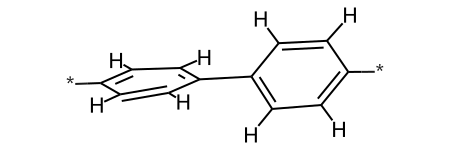

In [3]:
from enum import Enum, auto

class PrimitiveType(Enum):
    ALL_ATOM = auto()
    COARSE_GRAIN = auto()

# set what kind of behavior you want here!!
prim_type = PrimitiveType.ALL_ATOM
# prim_type = PrimitiveType.COARSE_GRAIN

# initialize reference primitive according to preference
if prim_type == PrimitiveType.ALL_ATOM:
    prim_ref, step_size = reference_primitive_atomistic('c1cc(*)ccc1c2ccc(*)cc2')
elif prim_type == PrimitiveType.COARSE_GRAIN:
    prim_ref, step_size = reference_primitive_ellipsoidal(semimajor=9.0, semiminor=4.0, bond_length=1.0)
else:
    raise ValueError('Invalid Primitive Type selected')


In [4]:
from typing import Generator
from mupt.geometry.random_walk import random_walk_jointed_chain
from mupt.geometry.transforms.linear import reflector


# generate steps from random walk
# def alt(l1 : float, l2 : float) -> Generator[float, None, None]:
#     '''Alternating step size generator for random walks'''
#     while True:
#         yield l1
#         yield l2


# NOTE: the specifics of the implementation here are unimiportant - just that you have a way to obtain centers and orientations
points = random_walk_jointed_chain(
    n_steps_max=50,
    step_size=step_size, # length of ellipsoid plus 2 halves of a bond on either end
    # step_size=alt(5.0, 10.0),
    clip_angle=np.pi*1/2, # maximum allowable angle between consecutive vectors
    starting_point=np.array([0, 0, 0], dtype=float),
)
steps = np.diff(points, axis=0)

# transform reference Primitive according to walk steps - process is uniform regardless of Shape definition
prims : list[Primitive] = []
for step_start, step_vector in zip(points[:-1], steps):
    unit_step_vector = step_vector / np.linalg.norm(step_vector)
    prim = prim_ref.copy()
    
    ## align +x-axis component with step using a Householder reflection (for greater numerical stability)
    ## note that this inverts handedness of orientation; for ellipsoids with equal semiminor axes, that doesn't matter
    orient_matr = reflector(np.array([1, 0, 0]) - unit_step_vector)
    center = step_start + step_vector/2
    transform = np.eye(4)
    transform[:-1, :-1] = orient_matr
    transform[:-1, -1] = center
    
    prims.append(prim_ref.affine_transformation(transform))

## 3) Visualize chain

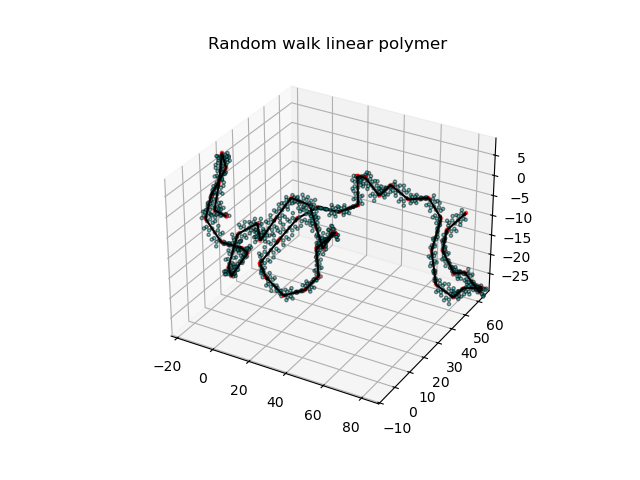

In [5]:
import matplotlib.pyplot as plt
%matplotlib ipympl
from mupt.geometry.shapes import Ellipsoid, PointCloud


# display shapes
plt.close()
fig = plt.figure()
fig.canvas.header_visible = False

ax = fig.add_subplot(projection='3d')
ax.autoscale(enable=True)
ax.set_title('Random walk linear polymer')

limits = np.vstack([points.min(axis=0), points.max(axis=0)]).T
for ax_sym, (ax_min, ax_max) in zip('xyz', limits):
    getattr(ax, f'set_{ax_sym}lim')(ax_min, ax_max)
    
_ = ax.scatter(*points.T, color='r', marker='.')
_ = ax.quiver(*points[:-1].T, *steps.T, arrow_length_ratio=0.1, color='k')
for prim in prims:
    if isinstance(prim.shape, PointCloud):
        shape_points = prim.shape.positions
        _ = ax.scatter(*shape_points.T, fc='c', ec='k', marker='.', alpha=0.5)
    elif isinstance(prim.shape, Ellipsoid):
        shape_points = prim.shape.surface_mesh(20, 20)
        _ = ax.plot_surface(*shape_points.T, color='c', alpha=0.5)

    for port in prim.ports:
        ax.plot(*np.vstack([port.linker_position, port.bridgehead_position]).T, 'r--')

## Next Steps:
* ~~Forcing port alignment (correct angle + dihedral between residues)~~
* Topology - support for nested Primitive networks in place of explicit RDKIt-like chemistry
* "Coagulation" - combining primitives into single molecule object
* Export: writing to other tools' formats